In [ ]:
!nvidia-smi

Sat Sep 20 23:17:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P0             27W /   70W |     280MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install requests pillow torch transformers matplotlib scipy

In [ ]:
!pip list | grep transformers
!pip list | grep pillow
!pip list | grep torch
!pip list | grep requests
!pip list | grep matplotlib
!pip list | grep scipy

sentence-transformers                 5.1.0
transformers                          4.56.1
pillow                                11.3.0
torch                                 2.8.0+cu126
torchao                               0.10.0
torchaudio                            2.8.0+cu126
torchdata                             0.11.0
torchsummary                          1.5.1
torchtune                             0.6.1
torchvision                           0.23.0+cu126
requests                              2.32.4
requests-oauthlib                     2.0.0
requests-toolbelt                     1.0.0
matplotlib                            3.10.0
matplotlib-inline                     0.1.7
matplotlib-venn                       1.1.2
scipy                                 1.16.1


In [ ]:
import requests
from PIL import Image
import torch
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm

In [ ]:
from transformers import Owlv2Processor, Owlv2ForObjectDetection

processor = Owlv2Processor.from_pretrained("google/owlv2-base-patch16-ensemble")
model = Owlv2ForObjectDetection.from_pretrained("google/owlv2-base-patch16-ensemble")

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/620M [00:00<?, ?B/s]

In [ ]:
def load_image_from_url(url: str) -> Image.Image:
    """
    Load an image from a URL and convert to RGB.
    Args:
        url (str): Image URL
    Returns:
        PIL.Image.Image: Loaded image
    """
    image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
    return image

In [ ]:
def detect_objects(
    image: Image.Image,
    queries: list[list[str]],
    processor: Owlv2Processor,
    model: Owlv2ForObjectDetection,
    threshold: float = 0.1
) -> list[dict]:
    """
    Run object detection on an image for given text queries.

    Args:
        image (PIL.Image.Image): Input image
        queries (list[list[str]]): A list of text lists, one per image (batch size = 1 here)
        processor: OWL-ViT processor
        model: OWL-ViT object detection model
        threshold (float): Minimum confidence for predictions

    Returns:
        List of dicts with keys: 'boxes', 'scores', 'labels'
    """
    inputs = processor(text=queries, images=[image], return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)

    # Prepare target size for rescaling boxes: (height, width)
    target_sizes = torch.Tensor([image.size[::-1]])
    results = processor.post_process_object_detection(
        outputs=outputs,
        target_sizes=target_sizes,
        threshold=threshold
    )
    return results


In [ ]:
import random
def display_image_with_boxes(
    image: Image.Image,
    results: list[dict],
    queries: list[list[str]],
    figsize: tuple = (10, 10)
) -> None:
    """
    Display an image with bounding boxes and labels, each box in a unique color.

    Args:
        image (PIL.Image.Image): Input image
        results (list[dict]): Detection outputs from detect_objects
        queries (list[list[str]]): Original text queries
        figsize (tuple): Figure size for display
    """
    plt.figure(figsize=figsize)
    plt.imshow(image)
    ax = plt.gca()

    # Assuming batch size of 1 for simplicity
    res = results[0]
    boxes, scores, labels = res["boxes"], res["scores"], res["labels"]

    # Assign a distinct random color for each detected object index
    colors = []
    for _ in range(len(boxes)):
        colors.append((random.random(), random.random(), random.random()))

    for (box, score, label), color in zip(zip(boxes, scores, labels), colors):
        xmin, ymin, xmax, ymax = box.tolist()
        ax.add_patch(plt.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            edgecolor=color, facecolor='none', linewidth=2
        ))
        text = queries[0][label]
        ax.text(
            xmin,
            ymin - 5,
            f"{text}: {score:.2f}",
            fontsize=12,
            backgroundcolor=color,
            color='white'
        )

    plt.axis('off')
    plt.show()

In [ ]:
import cv2
import numpy as np
import os

# Upload your video file (if not already done)
from google.colab import files
uploaded = files.upload()

# Get the filename of the uploaded video
video_file = list(uploaded.keys())[0]

# Create a directory to save the frames
output_dir = '/content/frames'
os.makedirs(output_dir, exist_ok=True)

# Load the video file using OpenCV
cap = cv2.VideoCapture(video_file)

# Get the total number of frames in the video
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Randomly select 5 unique frame indices
random_frame_indices = np.random.choice(frame_count, size=5, replace=False)

# Extract and save the selected frames
saved_frames = []
for idx in random_frame_indices:
    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)  # Set the frame position
    ret, frame = cap.read()
    if ret:
        frame_filename = os.path.join(output_dir, f'frame_{idx}.jpg')
        cv2.imwrite(frame_filename, frame)  # Save frame as image
        saved_frames.append(frame_filename)

# Close the video capture object
cap.release()

# Show the saved frame paths
saved_frames


Saving clip_76.mp4 to clip_76.mp4


['/content/frames/frame_357.jpg',
 '/content/frames/frame_47.jpg',
 '/content/frames/frame_248.jpg',
 '/content/frames/frame_225.jpg',
 '/content/frames/frame_58.jpg']

In [ ]:
from PIL import Image

# Open the image using PIL
image_path = '/content/frames/frame_225.jpg'  # Example path
image = Image.open(image_path)

# Display the image
image.show()


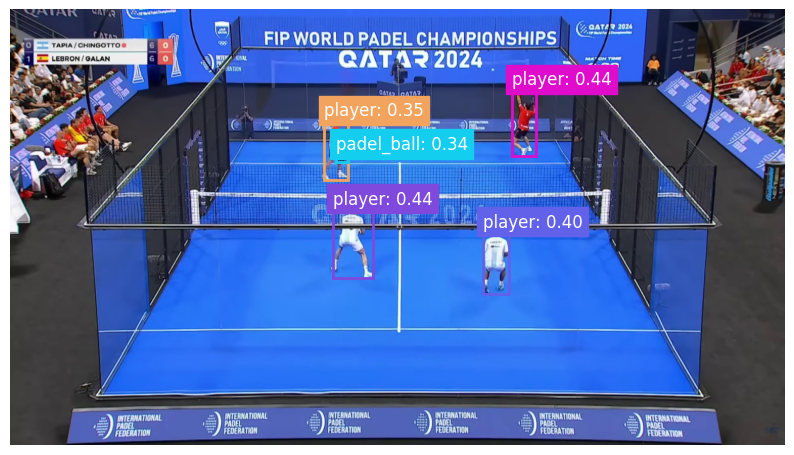

In [ ]:
queries = [["player", "padel_ball"]]
results = detect_objects(image, queries, processor, model, threshold=0.3)
display_image_with_boxes(image, results, queries)

In [ ]:
from PIL import Image

# Open the image using PIL
image_path = '/content/frames/frame_47.jpg'  # Example path
image2 = Image.open(image_path)

# Display the image
image2.show()

/usr/local/lib/python3.12/dist-packages/transformers/models/owlv2/processing_owlv2.py:201: FutureWarning: `post_process_object_detection` method is deprecated for OwlVitProcessor and will be removed in v5. Use `post_process_grounded_object_detection` instead.
  warnings.warn(


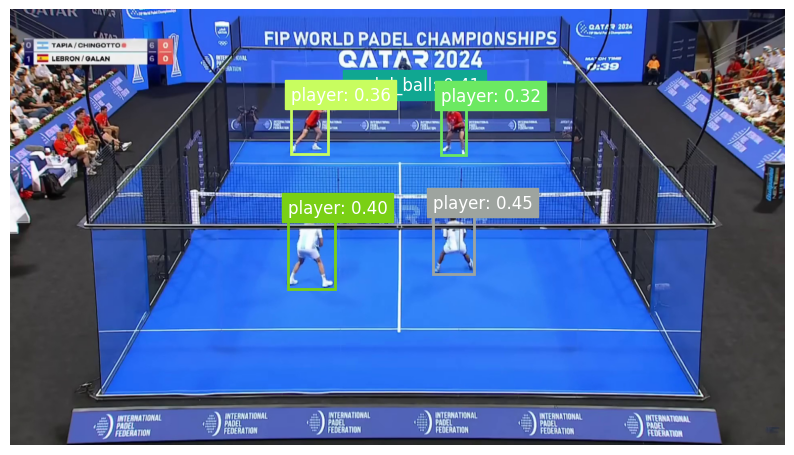

In [ ]:
queries = [["player", "padel_ball"]]
results = detect_objects(image2, queries, processor, model, threshold=0.3)
display_image_with_boxes(image2, results, queries)